In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=64
N_FOLDS = 5

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

20933
21887


In [7]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.5)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step()                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [8]:
n_classes = len(np.unique(train_val_labels))
clf = models.resnet18(pretrained=True)

for param in clf.parameters():
    param.requires_grad = False
    
clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
clf = clf.to('cuda')
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
submit = pd.DataFrame(columns=['Id'])


FOLD 1


epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 1.977460364154585


epoch:   3%|██▌                                                                        | 1/30 [01:51<54:06, 111.96s/it]


Epoch 001 train_loss: 1.9775     val_loss 0.9849 train_acc 0.5446 val_acc 0.7798
loss 0.5992413675010944


epoch:   7%|█████                                                                      | 2/30 [03:41<51:57, 111.33s/it]


Epoch 002 train_loss: 0.5992     val_loss 0.4410 train_acc 0.8457 val_acc 0.8883
loss 0.31033963081266014


epoch:  10%|███████▌                                                                   | 3/30 [05:32<49:57, 111.02s/it]


Epoch 003 train_loss: 0.3103     val_loss 0.3186 train_acc 0.9192 val_acc 0.9214
loss 0.21033511890002815


epoch:  13%|██████████                                                                 | 4/30 [07:22<48:00, 110.78s/it]


Epoch 004 train_loss: 0.2103     val_loss 0.2737 train_acc 0.9452 val_acc 0.9265
loss 0.15504095013879396


epoch:  17%|████████████▌                                                              | 5/30 [09:12<46:07, 110.70s/it]


Epoch 005 train_loss: 0.1550     val_loss 0.2226 train_acc 0.9589 val_acc 0.9450
loss 0.12364058942581423


epoch:  20%|███████████████                                                            | 6/30 [11:03<44:14, 110.59s/it]


Epoch 006 train_loss: 0.1236     val_loss 0.2060 train_acc 0.9681 val_acc 0.9475
loss 0.10076749580371072


epoch:  23%|█████████████████▌                                                         | 7/30 [12:53<42:22, 110.53s/it]


Epoch 007 train_loss: 0.1008     val_loss 0.1912 train_acc 0.9733 val_acc 0.9525
loss 0.057033176199784694


epoch:  27%|████████████████████                                                       | 8/30 [14:43<40:27, 110.32s/it]


Epoch 008 train_loss: 0.0570     val_loss 0.1868 train_acc 0.9857 val_acc 0.9545
loss 0.04870834812925974


epoch:  30%|██████████████████████▌                                                    | 9/30 [16:43<39:38, 113.25s/it]


Epoch 009 train_loss: 0.0487     val_loss 0.2009 train_acc 0.9878 val_acc 0.9548
loss 0.041269524106021284


epoch:  33%|████████████████████████▋                                                 | 10/30 [18:34<37:30, 112.54s/it]


Epoch 010 train_loss: 0.0413     val_loss 0.1661 train_acc 0.9906 val_acc 0.9632
loss 0.038899254136702796


epoch:  37%|███████████████████████████▏                                              | 11/30 [20:24<35:25, 111.88s/it]


Epoch 011 train_loss: 0.0389     val_loss 0.1678 train_acc 0.9905 val_acc 0.9623
loss 0.031297823058145435


epoch:  40%|█████████████████████████████▌                                            | 12/30 [22:14<33:24, 111.37s/it]


Epoch 012 train_loss: 0.0313     val_loss 0.1567 train_acc 0.9931 val_acc 0.9673
loss 0.026490055967169763


epoch:  43%|████████████████████████████████                                          | 13/30 [24:05<31:27, 111.04s/it]


Epoch 013 train_loss: 0.0265     val_loss 0.1939 train_acc 0.9930 val_acc 0.9534
loss 0.025648560352422186


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [25:55<29:33, 110.83s/it]


Epoch 014 train_loss: 0.0256     val_loss 0.1664 train_acc 0.9929 val_acc 0.9637
loss 0.014938775608181491


epoch:  50%|█████████████████████████████████████                                     | 15/30 [27:45<27:40, 110.72s/it]


Epoch 015 train_loss: 0.0149     val_loss 0.1633 train_acc 0.9970 val_acc 0.9662
loss 0.013897255218906803


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [29:36<25:47, 110.56s/it]


Epoch 016 train_loss: 0.0139     val_loss 0.1675 train_acc 0.9968 val_acc 0.9653
loss 0.012626172448858705


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [31:26<23:55, 110.42s/it]


Epoch 017 train_loss: 0.0126     val_loss 0.1698 train_acc 0.9970 val_acc 0.9625
loss 0.012206815339969986


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [33:16<22:03, 110.32s/it]


Epoch 018 train_loss: 0.0122     val_loss 0.1678 train_acc 0.9967 val_acc 0.9648
loss 0.00928654976553921


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [35:06<20:13, 110.29s/it]


Epoch 019 train_loss: 0.0093     val_loss 0.1755 train_acc 0.9979 val_acc 0.9669
loss 0.01087198037398924


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [36:57<18:23, 110.39s/it]


Epoch 020 train_loss: 0.0109     val_loss 0.1903 train_acc 0.9968 val_acc 0.9625
loss 0.010096123451528456


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [38:47<16:32, 110.22s/it]


Epoch 021 train_loss: 0.0101     val_loss 0.1926 train_acc 0.9973 val_acc 0.9609
loss 0.00807860204127641


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [40:38<14:43, 110.46s/it]


Epoch 022 train_loss: 0.0081     val_loss 0.1790 train_acc 0.9982 val_acc 0.9671
loss 0.006667860424011696


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [42:28<12:53, 110.44s/it]


Epoch 023 train_loss: 0.0067     val_loss 0.1667 train_acc 0.9984 val_acc 0.9641
loss 0.005785674369497216


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [44:18<11:01, 110.31s/it]


Epoch 024 train_loss: 0.0058     val_loss 0.1744 train_acc 0.9986 val_acc 0.9639
loss 0.006390017113421083


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 25/30 [46:08<09:11, 110.21s/it]


Epoch 025 train_loss: 0.0064     val_loss 0.1810 train_acc 0.9982 val_acc 0.9641
loss 0.005581423437034648


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 26/30 [47:58<07:20, 110.22s/it]


Epoch 026 train_loss: 0.0056     val_loss 0.1834 train_acc 0.9985 val_acc 0.9651
loss 0.005316290865244873


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 27/30 [49:48<05:30, 110.15s/it]


Epoch 027 train_loss: 0.0053     val_loss 0.1920 train_acc 0.9988 val_acc 0.9632
loss 0.005992224681027265


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 28/30 [51:38<03:40, 110.06s/it]


Epoch 028 train_loss: 0.0060     val_loss 0.1768 train_acc 0.9985 val_acc 0.9657
loss 0.004465447739012679


epoch:  97%|███████████████████████████████████████████████████████████████████████▌  | 29/30 [53:28<01:50, 110.02s/it]


Epoch 029 train_loss: 0.0045     val_loss 0.1896 train_acc 0.9989 val_acc 0.9667
loss 0.0041560530832706515


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [55:18<00:00, 110.63s/it]


Epoch 030 train_loss: 0.0042     val_loss 0.1858 train_acc 0.9990 val_acc 0.9664


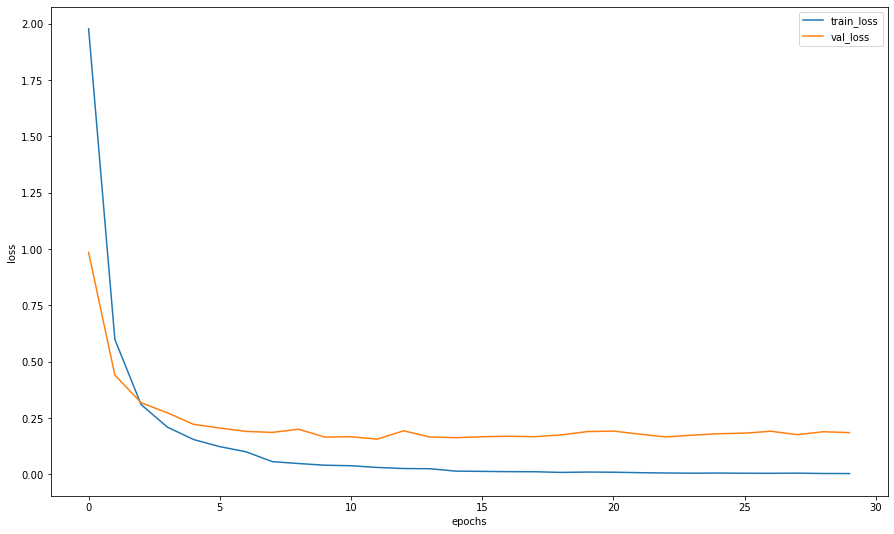


FOLD 2


epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 1.994536973327931


epoch:   3%|██▌                                                                        | 1/30 [01:58<57:26, 118.86s/it]


Epoch 001 train_loss: 1.9945     val_loss 0.9809 train_acc 0.5423 val_acc 0.7869
loss 0.6004284428031204


epoch:   7%|█████                                                                      | 2/30 [03:59<55:43, 119.40s/it]


Epoch 002 train_loss: 0.6004     val_loss 0.4277 train_acc 0.8463 val_acc 0.8901
loss 0.3065862123575684


epoch:  10%|███████▌                                                                   | 3/30 [05:57<53:34, 119.06s/it]


Epoch 003 train_loss: 0.3066     val_loss 0.2768 train_acc 0.9203 val_acc 0.9296
loss 0.20978258357828147


epoch:  13%|██████████                                                                 | 4/30 [07:50<50:47, 117.22s/it]


Epoch 004 train_loss: 0.2098     val_loss 0.2175 train_acc 0.9453 val_acc 0.9463
loss 0.15190372411756337


epoch:  17%|████████████▌                                                              | 5/30 [09:40<47:57, 115.09s/it]


Epoch 005 train_loss: 0.1519     val_loss 0.2145 train_acc 0.9606 val_acc 0.9504
loss 0.11806292190711212


epoch:  20%|███████████████                                                            | 6/30 [11:31<45:26, 113.62s/it]


Epoch 006 train_loss: 0.1181     val_loss 0.2034 train_acc 0.9674 val_acc 0.9550
loss 0.10202112627817328


epoch:  23%|█████████████████▌                                                         | 7/30 [13:21<43:12, 112.70s/it]


Epoch 007 train_loss: 0.1020     val_loss 0.1830 train_acc 0.9731 val_acc 0.9593
loss 0.054409289129521574


epoch:  27%|████████████████████                                                       | 8/30 [15:13<41:11, 112.35s/it]


Epoch 008 train_loss: 0.0544     val_loss 0.1765 train_acc 0.9864 val_acc 0.9612
loss 0.04679026933704685


epoch:  30%|██████████████████████▌                                                    | 9/30 [17:03<39:04, 111.63s/it]


Epoch 009 train_loss: 0.0468     val_loss 0.1815 train_acc 0.9875 val_acc 0.9628
loss 0.03879009108988091


epoch:  33%|████████████████████████▋                                                 | 10/30 [18:52<37:02, 111.11s/it]


Epoch 010 train_loss: 0.0388     val_loss 0.1752 train_acc 0.9900 val_acc 0.9646
loss 0.031507937365917234


epoch:  37%|███████████████████████████▏                                              | 11/30 [20:43<35:05, 110.84s/it]


Epoch 011 train_loss: 0.0315     val_loss 0.1848 train_acc 0.9921 val_acc 0.9639
loss 0.02676127079346462


epoch:  40%|█████████████████████████████▌                                            | 12/30 [22:33<33:13, 110.73s/it]


Epoch 012 train_loss: 0.0268     val_loss 0.1825 train_acc 0.9925 val_acc 0.9641
loss 0.026458688707972185


epoch:  43%|████████████████████████████████                                          | 13/30 [24:23<31:19, 110.55s/it]


Epoch 013 train_loss: 0.0265     val_loss 0.1767 train_acc 0.9929 val_acc 0.9662
loss 0.022309102600139213


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [26:13<29:25, 110.32s/it]


Epoch 014 train_loss: 0.0223     val_loss 0.1916 train_acc 0.9946 val_acc 0.9632
loss 0.015152999611160371


epoch:  50%|█████████████████████████████████████                                     | 15/30 [28:09<28:00, 112.04s/it]


Epoch 015 train_loss: 0.0152     val_loss 0.1886 train_acc 0.9962 val_acc 0.9651
loss 0.013312619365296959


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [30:08<26:37, 114.08s/it]


Epoch 016 train_loss: 0.0133     val_loss 0.1963 train_acc 0.9966 val_acc 0.9651
loss 0.01015127558269454


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [32:12<25:21, 117.05s/it]


Epoch 017 train_loss: 0.0102     val_loss 0.1931 train_acc 0.9977 val_acc 0.9685
loss 0.009936528459285577


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [34:04<23:05, 115.46s/it]


Epoch 018 train_loss: 0.0099     val_loss 0.2009 train_acc 0.9979 val_acc 0.9653
loss 0.009994425434028023


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [35:54<20:52, 113.89s/it]


Epoch 019 train_loss: 0.0100     val_loss 0.1879 train_acc 0.9971 val_acc 0.9698
loss 0.008036604070385667


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [37:44<18:48, 112.80s/it]


Epoch 020 train_loss: 0.0080     val_loss 0.2013 train_acc 0.9985 val_acc 0.9669
loss 0.007846513612309971


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [39:34<16:48, 112.06s/it]


Epoch 021 train_loss: 0.0078     val_loss 0.2044 train_acc 0.9981 val_acc 0.9692
loss 0.006584753280080967


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [41:25<14:53, 111.64s/it]


Epoch 022 train_loss: 0.0066     val_loss 0.2085 train_acc 0.9986 val_acc 0.9678
loss 0.005553542066352608


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [43:15<12:58, 111.24s/it]


Epoch 023 train_loss: 0.0056     val_loss 0.2049 train_acc 0.9987 val_acc 0.9678
loss 0.005292695909332161


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [45:06<11:05, 110.90s/it]


Epoch 024 train_loss: 0.0053     val_loss 0.2035 train_acc 0.9986 val_acc 0.9689
loss 0.004729103120094938


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 25/30 [46:56<09:14, 110.80s/it]


Epoch 025 train_loss: 0.0047     val_loss 0.2073 train_acc 0.9992 val_acc 0.9687
loss 0.004519289378359768


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 26/30 [48:47<07:23, 110.97s/it]


Epoch 026 train_loss: 0.0045     val_loss 0.2177 train_acc 0.9991 val_acc 0.9662
loss 0.004466065375193498


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 27/30 [50:40<05:34, 111.42s/it]


Epoch 027 train_loss: 0.0045     val_loss 0.2092 train_acc 0.9991 val_acc 0.9680
loss 0.004935922801400557


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 28/30 [52:29<03:41, 110.81s/it]


Epoch 028 train_loss: 0.0049     val_loss 0.2105 train_acc 0.9990 val_acc 0.9692
loss 0.003696454450268225


epoch:  97%|███████████████████████████████████████████████████████████████████████▌  | 29/30 [54:19<01:50, 110.36s/it]


Epoch 029 train_loss: 0.0037     val_loss 0.2123 train_acc 0.9993 val_acc 0.9671
loss 0.0029198685062026756


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [56:08<00:00, 112.28s/it]


Epoch 030 train_loss: 0.0029     val_loss 0.2125 train_acc 0.9995 val_acc 0.9696


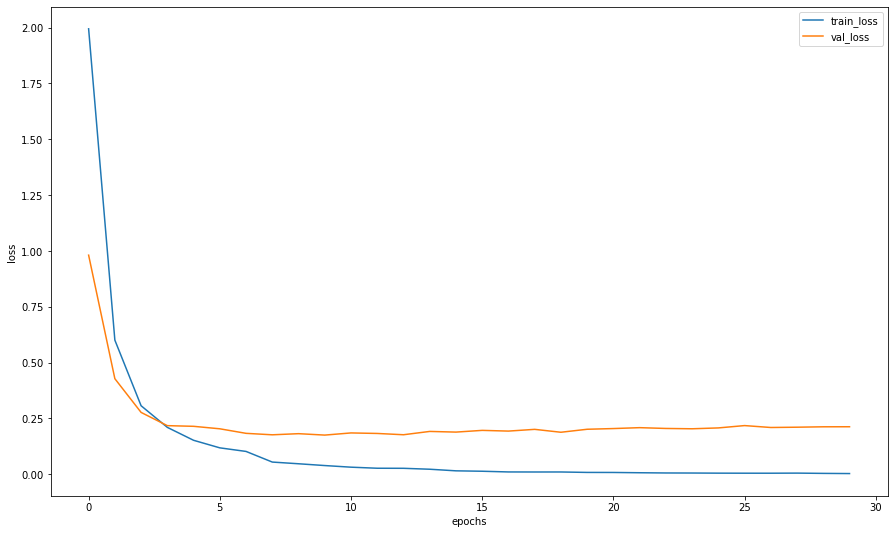


FOLD 3


epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 1.9156825100197783


epoch:   3%|██▌                                                                        | 1/30 [01:50<53:35, 110.88s/it]


Epoch 001 train_loss: 1.9157     val_loss 0.9450 train_acc 0.5661 val_acc 0.7942
loss 0.5899563166361275


epoch:   7%|█████                                                                      | 2/30 [03:40<51:34, 110.53s/it]


Epoch 002 train_loss: 0.5900     val_loss 0.4288 train_acc 0.8471 val_acc 0.8915
loss 0.30365049403473554


epoch:  10%|███████▌                                                                   | 3/30 [05:30<49:37, 110.29s/it]


Epoch 003 train_loss: 0.3037     val_loss 0.2828 train_acc 0.9210 val_acc 0.9253
loss 0.20980384605465993


epoch:  13%|██████████                                                                 | 4/30 [07:19<47:41, 110.05s/it]


Epoch 004 train_loss: 0.2098     val_loss 0.2304 train_acc 0.9436 val_acc 0.9397
loss 0.15601175386545862


epoch:  17%|████████████▌                                                              | 5/30 [09:09<45:47, 109.88s/it]


Epoch 005 train_loss: 0.1560     val_loss 0.2090 train_acc 0.9595 val_acc 0.9477
loss 0.126140074509338


epoch:  20%|███████████████                                                            | 6/30 [10:59<43:55, 109.83s/it]


Epoch 006 train_loss: 0.1261     val_loss 0.2401 train_acc 0.9654 val_acc 0.9381
loss 0.1024662761271919


epoch:  23%|█████████████████▌                                                         | 7/30 [12:48<42:06, 109.85s/it]


Epoch 007 train_loss: 0.1025     val_loss 0.1968 train_acc 0.9742 val_acc 0.9509
loss 0.05782306519220517


epoch:  27%|████████████████████                                                       | 8/30 [14:38<40:13, 109.72s/it]


Epoch 008 train_loss: 0.0578     val_loss 0.1536 train_acc 0.9850 val_acc 0.9639
loss 0.049433435583917974


epoch:  30%|██████████████████████▌                                                    | 9/30 [16:28<38:24, 109.74s/it]


Epoch 009 train_loss: 0.0494     val_loss 0.1521 train_acc 0.9884 val_acc 0.9637
loss 0.03911530225405279


epoch:  33%|████████████████████████▋                                                 | 10/30 [18:17<36:31, 109.56s/it]


Epoch 010 train_loss: 0.0391     val_loss 0.1781 train_acc 0.9907 val_acc 0.9614
loss 0.03507818912886198


epoch:  37%|███████████████████████████▏                                              | 11/30 [20:06<34:40, 109.48s/it]


Epoch 011 train_loss: 0.0351     val_loss 0.1586 train_acc 0.9905 val_acc 0.9648
loss 0.030277876866750552


epoch:  40%|█████████████████████████████▌                                            | 12/30 [21:55<32:50, 109.45s/it]


Epoch 012 train_loss: 0.0303     val_loss 0.1650 train_acc 0.9921 val_acc 0.9616
loss 0.02589080309009191


epoch:  43%|████████████████████████████████                                          | 13/30 [23:45<31:02, 109.58s/it]


Epoch 013 train_loss: 0.0259     val_loss 0.1685 train_acc 0.9941 val_acc 0.9618
loss 0.024018721314820475


epoch:  47%|██████████████████████████████████▌                                       | 14/30 [25:35<29:13, 109.61s/it]


Epoch 014 train_loss: 0.0240     val_loss 0.1971 train_acc 0.9941 val_acc 0.9552
loss 0.01468707553910433


epoch:  50%|█████████████████████████████████████                                     | 15/30 [27:25<27:26, 109.76s/it]


Epoch 015 train_loss: 0.0147     val_loss 0.1590 train_acc 0.9963 val_acc 0.9660
loss 0.010946665512986144


epoch:  53%|███████████████████████████████████████▍                                  | 16/30 [29:15<25:36, 109.72s/it]


Epoch 016 train_loss: 0.0109     val_loss 0.1813 train_acc 0.9981 val_acc 0.9639
loss 0.010816280015460776


epoch:  57%|█████████████████████████████████████████▉                                | 17/30 [31:04<23:45, 109.68s/it]


Epoch 017 train_loss: 0.0108     val_loss 0.1637 train_acc 0.9973 val_acc 0.9682
loss 0.010914944240989335


epoch:  60%|████████████████████████████████████████████▍                             | 18/30 [32:54<21:55, 109.65s/it]


Epoch 018 train_loss: 0.0109     val_loss 0.1692 train_acc 0.9974 val_acc 0.9650
loss 0.008427892937439296


epoch:  63%|██████████████████████████████████████████████▊                           | 19/30 [34:44<20:07, 109.81s/it]


Epoch 019 train_loss: 0.0084     val_loss 0.1694 train_acc 0.9983 val_acc 0.9680
loss 0.00770178688108987


epoch:  67%|█████████████████████████████████████████████████▎                        | 20/30 [36:34<18:17, 109.77s/it]


Epoch 020 train_loss: 0.0077     val_loss 0.1701 train_acc 0.9980 val_acc 0.9671
loss 0.006535293305742696


epoch:  70%|███████████████████████████████████████████████████▊                      | 21/30 [38:24<16:30, 110.01s/it]


Epoch 021 train_loss: 0.0065     val_loss 0.1699 train_acc 0.9989 val_acc 0.9692
loss 0.006107997295150437


epoch:  73%|██████████████████████████████████████████████████████▎                   | 22/30 [40:25<15:04, 113.07s/it]


Epoch 022 train_loss: 0.0061     val_loss 0.1844 train_acc 0.9987 val_acc 0.9634
loss 0.005812576905024296


epoch:  77%|████████████████████████████████████████████████████████▋                 | 23/30 [42:31<13:39, 117.14s/it]


Epoch 023 train_loss: 0.0058     val_loss 0.1707 train_acc 0.9985 val_acc 0.9660
loss 0.0055459927450780405


epoch:  80%|███████████████████████████████████████████████████████████▏              | 24/30 [44:38<12:00, 120.01s/it]


Epoch 024 train_loss: 0.0055     val_loss 0.1805 train_acc 0.9987 val_acc 0.9676
loss 0.004530244960164016


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 25/30 [46:45<10:10, 122.17s/it]


Epoch 025 train_loss: 0.0045     val_loss 0.1874 train_acc 0.9990 val_acc 0.9634
loss 0.005256979973306736


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 26/30 [48:53<08:15, 123.75s/it]


Epoch 026 train_loss: 0.0053     val_loss 0.1809 train_acc 0.9988 val_acc 0.9628
loss 0.004728654423369034


epoch:  90%|██████████████████████████████████████████████████████████████████▌       | 27/30 [51:01<06:15, 125.17s/it]


Epoch 027 train_loss: 0.0047     val_loss 0.1785 train_acc 0.9989 val_acc 0.9676
loss 0.004660911685324572


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 28/30 [53:01<04:07, 123.71s/it]


Epoch 028 train_loss: 0.0047     val_loss 0.1853 train_acc 0.9990 val_acc 0.9655
loss 0.00457448008938159


epoch:  97%|███████████████████████████████████████████████████████████████████████▌  | 29/30 [54:57<02:01, 121.26s/it]


Epoch 029 train_loss: 0.0046     val_loss 0.1823 train_acc 0.9989 val_acc 0.9680
loss 0.00378834042528741


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [56:48<00:00, 113.62s/it]


Epoch 030 train_loss: 0.0038     val_loss 0.1748 train_acc 0.9994 val_acc 0.9689


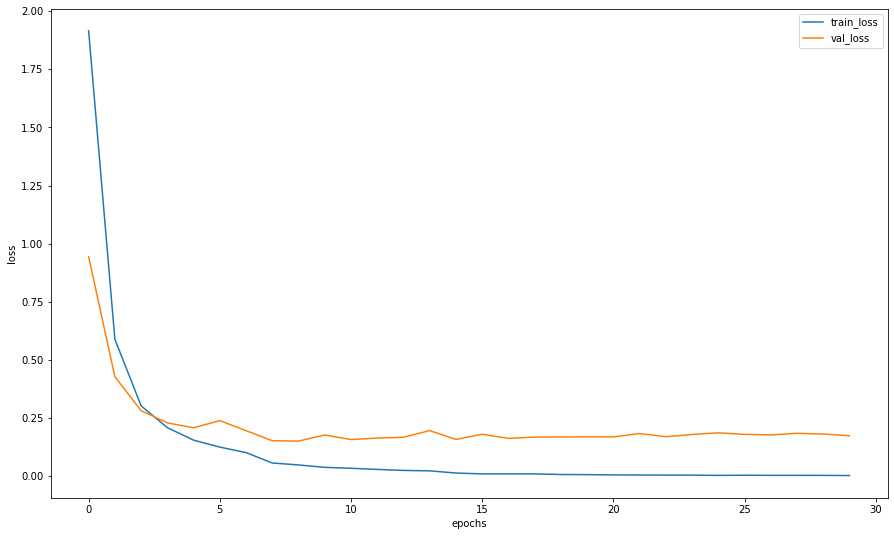


FOLD 4


epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 1.9442688486699988


epoch:   3%|██▌                                                                        | 1/30 [01:58<57:19, 118.59s/it]


Epoch 001 train_loss: 1.9443     val_loss 0.9506 train_acc 0.5592 val_acc 0.7921
loss 0.5904931560711885


epoch:   7%|█████                                                                      | 2/30 [03:53<54:52, 117.58s/it]


Epoch 002 train_loss: 0.5905     val_loss 0.3826 train_acc 0.8492 val_acc 0.8976
loss 0.2966144558363544


epoch:  10%|███████▌                                                                   | 3/30 [05:51<52:54, 117.58s/it]


Epoch 003 train_loss: 0.2966     val_loss 0.2915 train_acc 0.9242 val_acc 0.9189
loss 0.21530494910012238


epoch:  13%|██████████                                                                 | 4/30 [07:44<50:22, 116.24s/it]


Epoch 004 train_loss: 0.2153     val_loss 0.2441 train_acc 0.9453 val_acc 0.9367
loss 0.160259438926904


epoch:  17%|████████████▌                                                              | 5/30 [09:38<48:12, 115.71s/it]


Epoch 005 train_loss: 0.1603     val_loss 0.2188 train_acc 0.9589 val_acc 0.9397
loss 0.13123588964879207


epoch:  20%|███████████████                                                            | 6/30 [11:31<45:52, 114.70s/it]


Epoch 006 train_loss: 0.1312     val_loss 0.2013 train_acc 0.9657 val_acc 0.9507
loss 0.09553145718240078


epoch:  23%|█████████████████▌                                                         | 7/30 [13:23<43:41, 113.99s/it]


Epoch 007 train_loss: 0.0955     val_loss 0.1893 train_acc 0.9763 val_acc 0.9538


epoch:  23%|█████████████████▌                                                         | 7/30 [13:35<44:39, 116.49s/it]


RuntimeError: CUDA error: misaligned address

In [10]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = models.resnet18(pretrained=True)
    clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
    clf = clf.to('cuda')
        
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))    
    submit[f'fold_{fold+1}'] = preds

In [ ]:
torch.cuda.empty_cache()

###  Submission

In [ ]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('./out/PROD_resnet18_sgd_lrs7.csv', index=False)
submit.head()